In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. SoftMax

### 1.1 效果示例

softmax 能把输出值转换成对应概率，output的所有entry相加的最终值为1

即 T = 1 

In [2]:
logits = np.array([-1,2,3,6])

In [3]:
softmax_1 = np.exp(logits)/sum(np.exp(logits))

In [4]:
softmax_1

array([8.53011713e-04, 1.71331982e-02, 4.65728615e-02, 9.35440929e-01])

In [5]:
total = 0
for i in softmax_1:
    total += i
print(total)

1.0


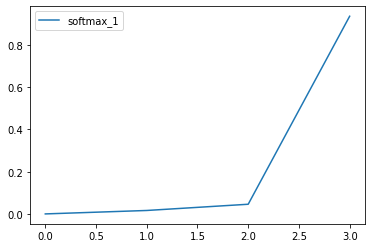

In [6]:
plt.plot(softmax_1,label="softmax_1")
plt.legend()
plt.show()

### 1.2 不同温度对应的softmax效果

可以观察到，温度越大各个种类的输出结果趋于平均。

In [7]:
def distill_softmax(logits,temperature):
    output = np.exp(logits/temperature)/sum(np.exp(logits/temperature))
    return output

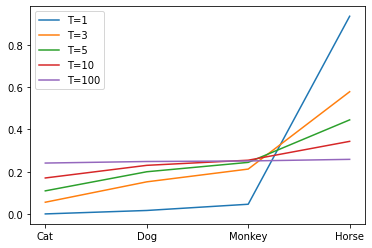

In [8]:
plt.plot(softmax_1, label='T=1')

softmax_3 = distill_softmax(logits,3)
plt.plot(softmax_3, label='T=3')

softmax_5 = distill_softmax(logits,5)
plt.plot(softmax_5, label='T=5')

softmax_10 = distill_softmax(logits,10)
plt.plot(softmax_10, label='T=10')

softmax_100 = distill_softmax(logits,100)
plt.plot(softmax_100, label='T=100')


plt.xticks(np.arange(4),['Cat','Dog','Monkey','Horse'])
plt.legend()
plt.show()

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Files already downloaded and verified
Files already downloaded and verified


In [11]:
Teach_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)

Using cache found in /Users/chenpuquan/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/chenpuquan/opt/anaconda3/envs/distill/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/chenpuquan/opt/anaconda3/envs/distill/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Teach_model.parameters(), lr=0.001, momentum=0.9)

In [13]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = Teach_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 5.626
[1,  4000] loss: 4.891
[1,  6000] loss: 4.314
[1,  8000] loss: 3.779
[1, 10000] loss: 3.695
[1, 12000] loss: 3.378
[2,  2000] loss: 3.215
[2,  4000] loss: 3.152
[2,  6000] loss: 3.006
[2,  8000] loss: 2.875
[2, 10000] loss: 2.814
[2, 12000] loss: 2.754


rosetta error: thread_suspend failed


RuntimeError: DataLoader worker (pid(s) 41706) exited unexpectedly